In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
from warnings import filterwarnings
from chainer import serializers
#print(check_output(["dir", "C:/Users/User/Documents/RL_"]).decode("utf8"))
filterwarnings(action='ignore', category=DeprecationWarning, message='`np.bool` is a deprecated alias')
filterwarnings(action='ignore', category=np.VisibleDeprecationWarning)  
# Any results you write to the current directory are saved as output.

D:\Anaconda\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
D:\Anaconda\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
D:\Anaconda\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
D:\Anaconda\lib\site-packages\pkg_resources\__init__.py:123: PkgResourcesDeprecationWarning: 4.0.0-unsupported is an invalid version and will not be supported in a future release
  warnings.warn(


In [3]:
import time
import copy
import numpy as np
import array as arr
import pandas as pd
import chainer
import chainer.functions as F
import chainer.links as L
import matplotlib.pyplot as plt
from plotly.offline import plot
import datetime
import plotly.graph_objects as go
#from plotly import tools
#from plotly.graph_objs import *
#from plotly.offline import init_notebook_mode, iplot, iplot_mpl

In [4]:
data = pd.read_csv('C:/Users/User/Documents/RL_/Data/Stocks/SPY_Gold.txt')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
print(data.index.min(), data.index.max())
data.head()

2001-01-02 00:00:00 2019-12-30 00:00:00


,Open,High,Low,Close,Adj Close,Volume,Gold_Adj Close
Date,,,,,,,
2001-01-02,1320.280029,1320.280029,1276.050049,1283.270020,1283.270020,1129400000,268.399994
2001-01-03,1283.270020,1347.760010,1274.619995,1347.560059,1347.560059,1880700000,268.000000
2001-01-04,1347.560059,1350.239990,1329.140015,1333.339966,1333.339966,2131000000,267.299988
2001-01-05,1333.339966,1334.770020,1294.949951,1298.349976,1298.349976,1430800000,268.000000
2001-01-08,1298.349976,1298.349976,1276.290039,1295.859985,1295.859985,1115500000,268.000000


In [5]:
start_date = datetime.datetime(2001, 1, 1)
end_date = datetime.datetime(2019, 12, 31)
total_days = (end_date - start_date).days
train_days = int(total_days * 0.5)
test_start_date = start_date + datetime.timedelta(days=train_days)
date_split = test_start_date.date()
train = data[:date_split]
test = data[date_split:]
print("訓練", start_date.date(), "到", test_start_date.date())
print("測試", test_start_date.date(), "到", end_date.date())

訓練 2001-01-01 到 2010-07-02
測試 2010-07-02 到 2019-12-31


In [6]:
def plot_train_test(train, test, date_split):
    # 创建图形
    train_candle = go.Candlestick(x=train.index, open=train['Open'], high=train['High'], low=train['Low'], close=train['Close'], name='Train')
    test_candle = go.Candlestick(x=test.index, open=test['Open'], high=test['High'], low=test['Low'], close=test['Close'], name='Test')
    
    fig = go.Figure(data=[train_candle, test_candle])
    
    # 添加分割线
    fig.add_shape(
        type="line",
        x0=date_split, y0=min(min(train['Low']), min(test['Low'])),
        x1=date_split, y1=max(max(train['High']), max(test['High'])),
        line=dict(color="Black", width=2)
    )
    
    # 添加注释
    fig.add_annotation(
        x=date_split, y=max(max(train['High']), max(test['High'])), ax=0, ay=-30,
        xref='x', yref='y',
        showarrow=True, arrowhead=1,
        text="Start of Test Data"
    )
    
    # 更新布局
    fig.update_layout(title='Train and Test Data Visualization', xaxis_title='Date', yaxis_title='Price')
    
    # 显示图形
    plot(fig)

# 调用函数
plot_train_test(train, test, date_split)

In [7]:
class Environment1:
    
    def __init__(self, data, history_t=90):
        self.data = data
        self.history_t = history_t
        self.reset()
        
    def reset(self):
        self.t = 0
        self.done = False
        self.profits = 10000 #初始資金
        self.count = []
        self.positions = []
        self.position_value = 0
        self.brok_rate=0.0009
        self.max_trade_percent = 0.8
        self.tbrokerage = 0
        self.history = [0 for _ in range(self.history_t)]
        self.Act0=0
        self.Act1=0
        self.Act2=0
        self.RW_p=0
        self.RW_n=0
        self.RW_p_v=0
        self.RW_n_v=0
        return [self.position_value] + self.history # obs
    
    def step(self, act, amount):
        if self.t >= len(self.data) - 1:
            self.done = True
            return [self.position_value] + self.history, 0, self.done
        reward = 0
        #print(act)
        #print(amount)
        # act = 0: stay, 1: buy, 2: sell
        if act == 1:
            if self.profits != 0:
                max_trade_amount = self.profits*self.max_trade_percent
                stock_price = self.data.iloc[self.t, :]['Close']
                count = max_trade_amount / stock_price
                #self.tbrokerage = self.brok_rate*self.data.iloc[self.t, :]['Close']
                buyin = stock_price * count
                self.profits = self.profits - buyin 
                #print('\t'.join(map(str, ['buy',self.data.iloc[self.t, :]['Close'], amount, buyin, self.profits])))
                self.positions.append(stock_price)
                self.count.append(count)
                self.Act1+=1
                #print('\t'.join(map(str, ['buy', amount, buyin, self.profits])))
                
        elif act == 2: # sell
            if len(self.positions) > 0:
                sell_ratio = self.determine_sell_ratio(amount)
                num_positions_to_sell = int(len(self.positions) * sell_ratio)

                for i in range(num_positions_to_sell):
                    sell_price = self.data.iloc[self.t, :]['Close']
                    buy_price = self.positions[i]
                    count = self.count[i]
                    abs_num = (sell_price - buy_price) * count
                    if abs_num > 0: 
                        self.RW_p += 1 
                        self.RW_p_v += abs_num
                    else: 
                        self.RW_n += 1
                        self.RW_n_v += abs(abs_num)
                    reward += sell_price * count
                    self.profits += sell_price * count
                self.positions = self.positions[num_positions_to_sell:]
                self.count = self.count[num_positions_to_sell:]
                self.Act2 += 1    
        
        else :
            self.Act0+=1
        
        # set next time
        self.t += 1
        self.position_value = 0
        for p in self.positions:
            self.position_value += (self.data.iloc[self.t, :]['Close'] - p)
        self.history.pop(0)
        self.history.append(self.data.iloc[self.t, :]['Close'] - self.data.iloc[(self.t-1), :]['Close'])
        
        # clipping reward
        if reward > 0:
            reward = 1
        elif reward < 0:
            reward = -1
        
        return [self.position_value] + self.history, reward, self.done # obs, reward, done
    def determine_sell_ratio(self, signal_strength):
        # Example thresholds and ratios
        thresholds = [0.2, 0.5, 0.8]
        ratios = [0.25, 0.5, 0.75]

        for i, threshold in enumerate(thresholds):
            if signal_strength < threshold:
                return ratios[i]
        return ratios[0]  # Sell the largest ratio but not everything if the signal is very strong

In [8]:
env = Environment1(train)
print(env.reset())
for _ in range(3):
    pact = np.random.randint(3)
    amount = 0.333
    print(env.step(pact,amount))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 64.29003899999998], 0, False)
([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 64.29003899999998, -14.220092999999906], 0, False)
([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [9]:
# DQN

def train_dqn(env):

    class Q_Network(chainer.Chain):

        def __init__(self, input_size, hidden_size, output_size):
            super(Q_Network, self).__init__(
                fc1 = L.Linear(input_size, hidden_size),
                fc2 = L.Linear(hidden_size, hidden_size),
                fc3 = L.Linear(hidden_size, output_size)
            )

        def __call__(self, x):
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            y = self.fc3(h)
            return y

        def reset(self):
            self.zerograds()

    Q = Q_Network(input_size=env.history_t+1, hidden_size=100, output_size=3)
    Q_ast = copy.deepcopy(Q)
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(Q)

    epoch_num = 200
    step_max = len(env.data)-1
    memory_size = 200
    batch_size = 20
    epsilon = 1.0
    epsilon_decrease = 1e-3
    epsilon_min = 0.1
    start_reduce_epsilon = 200
    train_freq = 10
    update_q_freq = 20
    gamma = 0.97
    show_log_freq = 1
    confidence_threshold_buy = 0.1
    confidence_threshold_sell = 0.8
    memory = []
    total_step = 0
    total_rewards = []
    total_losses = []
    start = time.time()

    print('\t'.join(map(str, ['epoch','profit','          ','buy','sell','hold'])))
    for epoch in range(epoch_num):

        pobs = env.reset()
        step = 0
        done = False
        total_reward = 0
        total_loss = 0
        RandAct = 0
        NRandAct = 0
        while not done and step < step_max:
            #if step==2264 :
            #    env.profits=10000
            #    env.count=0
                
            # select act
            pact = np.random.randint(3)
            amount = 0.25
            if np.random.rand() > epsilon:
                q_values = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
                softmax_q_values = F.softmax(q_values).data
                #if step==0:print('\t'.join(map(str, [pact])))
                #max_confidence = softmax_q_values
                amount = softmax_q_values.ravel()[pact]
                #pact = np.argmax(softmax_q_values)
                pact = np.random.choice(3, p=softmax_q_values.ravel())
                # act = 0: stay, 1: buy, 2: sell
                if pact == 2:
                    if amount < confidence_threshold_sell:  # confidence_threshold 阈值 
                        pact = 0
                if pact == 1:
                    if amount < confidence_threshold_buy:  # confidence_threshold 阈值
                        pact = 0
                #if epoch > 100 : print('\t'.join(map(str, [pact,amount])))
                NRandAct+=1
            else:
                RandAct+=1
                if pact==0: amount = 0.5
            # act
            obs, reward, done = env.step(pact,amount)

            # add memory
            memory.append((pobs, pact, reward, obs, done))
            if len(memory) > memory_size:
                memory.pop(0)

            # train or update q
            if len(memory) == memory_size:
                if total_step % train_freq == 0:
                    shuffled_memory = np.random.permutation(memory)
                    memory_idx = range(len(shuffled_memory))
                    for i in memory_idx[::batch_size]:
                        batch = np.array(shuffled_memory[i:i+batch_size])
                        b_pobs = np.array(batch[:, 0].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_pact = np.array(batch[:, 1].tolist(), dtype=np.int32)
                        b_reward = np.array(batch[:, 2].tolist(), dtype=np.int32)
                        b_obs = np.array(batch[:, 3].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_done = np.array(batch[:, 4].tolist(), dtype=np.bool)

                        q = Q(b_pobs)
                        maxq = np.max(Q_ast(b_obs).data, axis=1)
                        target = copy.deepcopy(q.data)
                        for j in range(batch_size):
                            target[j, b_pact[j]] = b_reward[j]+gamma*maxq[j]*(not b_done[j])
                        Q.reset()
                        loss = F.mean_squared_error(q, target)
                        total_loss += loss.data
                        loss.backward()
                        optimizer.update()

                if total_step % update_q_freq == 0:
                    Q_ast = copy.deepcopy(Q)

            # epsilon
            if epsilon > epsilon_min and total_step > start_reduce_epsilon:
                epsilon -= epsilon_decrease

            # next step
            total_reward += reward
            pobs = obs
            step += 1
            total_step += 1

        total_rewards.append(total_reward)
        total_losses.append(total_loss)

        if (epoch+1) % show_log_freq == 0:
            log_reward = sum(total_rewards[((epoch+1)-show_log_freq):])/show_log_freq
            log_loss = sum(total_losses[((epoch+1)-show_log_freq):])/show_log_freq
            #log_profits = 0
            log_profits = env.profits
            if len(env.count) != 0:
                for i in range(0,len(env.positions)):
                    log_profits += env.count[i]*env.data.iloc[env.t, :]['Close']
            else :
                log_profits = env.profits
            elapsed_time = time.time()-start
            
            print('\t'.join(map(str, [epoch+1,log_profits,env.Act1,env.Act2,env.Act0])))
            print('\t'.join(map(str, [epoch+1,env.RW_p,env.RW_n,env.RW_p_v,env.RW_n_v])))
            start = time.time()
    chainer.serializers.save_npz('2001_Gold_dqn_model.npz', Q)        
    return Q, total_losses, total_rewards
    

In [10]:
Q, total_losses, total_rewards = train_dqn(Environment1(train))

epoch	profit	          	buy	sell	hold
1	11070.78190592418	526	290	1571
1	275	246	17517.670599300403	14841.306271771597
2	7006.673153564939	304	188	1896
2	150	149	6949.935686893029	9486.548539338683
3	5991.385421785775	277	181	1930
3	136	138	6961.007580177814	10001.319033891781
4	9290.827098467436	271	204	1913
4	162	103	8799.253828426115	8403.197954172314
5	10753.464129307915	302	191	1895
5	178	120	10808.835166286677	8773.723376726002
6	8992.551601198757	265	238	1885
6	157	100	11582.430514862503	11900.970793719207
7	7538.999827700422	410	188	1790
7	218	185	8941.35348398539	11402.27529517702
8	7179.782375960298	517	150	1721
8	288	216	8121.160515050825	10266.486736837853
9	8462.367033205994	566	152	1670
9	301	245	13192.14454289525	14200.096025828625
10	11346.31661796734	574	167	1647
10	329	228	16799.700132117057	13392.454952677313
11	7613.2141277448645	574	152	1662
11	311	248	10341.526181686548	12149.205642759882
12	7093.945380404195	635	148	1605
12	350	270	9527.080566887396	11575.4680181

102	7275.710811766518	604	81	1703
102	339	245	9639.031924000594	11219.36380018088
103	8014.104424004983	675	75	1638
103	360	307	8942.729243119633	10581.602952130306
104	5929.474239035347	596	91	1700
104	306	281	7237.050987361649	10756.66940490634
105	7013.97084427488	577	89	1722
105	315	259	7202.329446064262	9829.115488303485
106	7274.581113145832	611	85	1692
106	323	277	9661.140823795886	11414.411759492286
107	8808.024620727017	542	93	1753
107	306	215	11742.328513453776	11504.29880474431
108	7792.055244400481	623	85	1679
108	295	281	9849.799970418215	11267.97679452434
109	7991.767447276257	596	78	1714
109	313	253	10327.098796470182	11801.117114460823
110	9324.401585691858	592	108	1688
110	360	217	12238.523795453712	12408.807386877774
111	8750.339556604398	677	76	1635
111	335	319	9931.371396956176	10218.11116501478
112	10943.663859650625	566	96	1726
112	312	245	13468.032526037561	11343.308130021998
113	9334.371482960894	602	70	1716
113	343	237	10812.52007784487	10567.396252240285
114	1

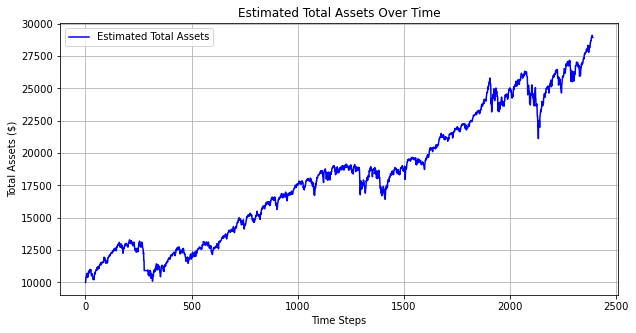

Final profits: 28936.235074372922


In [11]:
import matplotlib.pyplot as plt

def test_dqn(test_env, Q, confidence_threshold_buy=0.1, confidence_threshold_sell=0.8):
    # 重置环境
    pobs = test_env.reset()
    test_env.profits = 10000  # 重置初始资金
    test_acts = []
    test_rewards = []
    estimated_total_assets = [test_env.profits]  # 记录每步的总资产，初始资金为起始值

    while not test_env.done:
        # 使用DQN产生行动的概率分布
        q_values = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
        softmax_q_values = F.softmax(q_values).data
        pact = np.random.choice(3, p=softmax_q_values.ravel())
        
        # 根据设定的阈值判断是否执行买入或卖出
        amount = softmax_q_values.ravel()[pact]
        if pact == 2 and amount < confidence_threshold_sell:
            pact = 0
        elif pact == 1 and amount < confidence_threshold_buy:
            pact = 0
        
        # 执行行动
        obs, reward, done = test_env.step(pact, amount)
        test_acts.append(pact)
        test_rewards.append(reward)
        pobs = obs

        # 估算总资产
        stock_value = sum(c * test_env.data.iloc[test_env.t]['Close'] for c in test_env.count)
        total_assets = test_env.profits + stock_value
        estimated_total_assets.append(total_assets)

    # 绘制估算总资产的折线图
    plt.figure(figsize=(10, 5))
    plt.plot(estimated_total_assets, label='Estimated Total Assets', color='blue')
    plt.title('Estimated Total Assets Over Time')
    plt.xlabel('Time Steps')
    plt.ylabel('Total Assets ($)')
    plt.legend()
    plt.grid(True)
    plt.show()

    final_profits = total_assets
    return test_acts, test_rewards, final_profits
def load_and_test_dqn(test_env):

    class Q_Network(chainer.Chain):

        def __init__(self, input_size, hidden_size, output_size):
            super(Q_Network, self).__init__(
                fc1 = L.Linear(input_size, hidden_size),
                fc2 = L.Linear(hidden_size, hidden_size),
                fc3 = L.Linear(hidden_size, output_size)
            )

        def __call__(self, x):
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            y = self.fc3(h)
            return y

        def reset(self):
            self.zerograds()
    Q_loaded = Q_Network(input_size=test_env.history_t+1, hidden_size=100, output_size=3)
    chainer.serializers.load_npz('2001_Gold_dqn_model.npz', Q_loaded)
    
    # 现在使用加载的模型来进行测试
    test_acts, test_rewards, test_profits = test_dqn(test_env, Q_loaded)
    #print("Test actions:", test_acts)
    #print("Test rewards:", test_rewards)
    print("Final profits:", test_profits)
# 调用函数进行测试
test_data = test  # 确保已正确设置测试数据
test_env = Environment1(data=test_data, history_t=90)
load_and_test_dqn(test_env)

In [12]:
def plot_loss_reward(total_losses, total_rewards):

    figure = tools.make_subplots(rows=1, cols=2, subplot_titles=('loss', 'reward'), print_grid=False)
    figure.append_trace(Scatter(y=total_losses, mode='lines', line=dict(color='skyblue')), 1, 1)
    figure.append_trace(Scatter(y=total_rewards, mode='lines', line=dict(color='orange')), 1, 2)
    figure['layout']['xaxis1'].update(title='epoch')
    figure['layout']['xaxis2'].update(title='epoch')
    figure['layout'].update(height=400, width=900, showlegend=False)
    iplot(figure)
    

In [13]:
# Double DQN

def train_ddqn(env):

    class Q_Network(chainer.Chain):

        def __init__(self, input_size, hidden_size, output_size):
            super(Q_Network, self).__init__(
                fc1 = L.Linear(input_size, hidden_size),
                fc2 = L.Linear(hidden_size, hidden_size),
                fc3 = L.Linear(hidden_size, output_size)
            )

        def __call__(self, x):
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            y = self.fc3(h)
            return y

        def reset(self):
            self.zerograds()    
    Q = Q_Network(input_size=env.history_t+1, hidden_size=100, output_size=3)
    Q_ast = copy.deepcopy(Q)
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(Q)

    epoch_num = 200
    step_max = len(env.data)-1
    memory_size = 200
    batch_size = 50
    epsilon = 1.0
    epsilon_decrease = 1e-3
    epsilon_min = 0.1
    start_reduce_epsilon = 200
    train_freq = 10
    update_q_freq = 20
    confidence_threshold_buy = 0.1
    confidence_threshold_sell = 0.8
    gamma = 0.97
    show_log_freq = 1

    memory = []
    total_step = 0
    total_rewards = []
    total_losses = []

    start = time.time()
    print('\t'.join(map(str, ['epoch','profit','          ','buy','sell','hold'])))
    for epoch in range(epoch_num):

        pobs = env.reset()
        step = 0
        done = False
        total_reward = 0
        total_loss = 0
        RandAct = 0
        NRandAct = 0
        while not done and step < step_max:
            #if step==2264 :
            #    env.profits=10000
            #    env.count=0
            pact = np.random.randint(3)
            amount = 0.25
            if np.random.rand() > epsilon:
                q_values = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
                softmax_q_values = F.softmax(q_values).data
                #if step==0:print('\t'.join(map(str, [pact])))
                #max_confidence = softmax_q_values
                amount = softmax_q_values.ravel()[pact]
                pact = np.random.choice(3, p=softmax_q_values.ravel())
                # act = 0: stay, 1: buy, 2: sell
                if pact == 2:
                    if amount < confidence_threshold_sell:  # confidence_threshold 阈值 
                        pact = 0
                if pact == 1:
                    if amount < confidence_threshold_buy:  # confidence_threshold 阈值
                        pact = 0
                #if epoch > 100 : print('\t'.join(map(str, [pact,amount])))
                NRandAct+=1
            else:
                RandAct+=1
                if pact==0: amount = 0.5
            # act
            obs, reward, done = env.step(pact,amount)

            # add memory
            memory.append((pobs, pact, reward, obs, done))
            if len(memory) > memory_size:
                memory.pop(0)

            # train or update q
            if len(memory) == memory_size:
                if total_step % train_freq == 0:
                    shuffled_memory = np.random.permutation(memory)
                    memory_idx = range(len(shuffled_memory))
                    for i in memory_idx[::batch_size]:
                        batch = np.array(shuffled_memory[i:i+batch_size])
                        b_pobs = np.array(batch[:, 0].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_pact = np.array(batch[:, 1].tolist(), dtype=np.int32)
                        b_reward = np.array(batch[:, 2].tolist(), dtype=np.int32)
                        b_obs = np.array(batch[:, 3].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_done = np.array(batch[:, 4].tolist(), dtype=np.bool)

                        q = Q(b_pobs)
                        """ <<< DQN -> Double DQN
                        maxq = np.max(Q_ast(b_obs).data, axis=1)
                        === """
                        indices = np.argmax(q.data, axis=1)
                        maxqs = Q_ast(b_obs).data
                        """ >>> """
                        target = copy.deepcopy(q.data)
                        for j in range(batch_size):
                            """ <<< DQN -> Double DQN
                            target[j, b_pact[j]] = b_reward[j]+gamma*maxq[j]*(not b_done[j])
                            === """
                            target[j, b_pact[j]] = b_reward[j]+gamma*maxqs[j, indices[j]]*(not b_done[j])
                            """ >>> """
                        Q.reset()
                        loss = F.mean_squared_error(q, target)
                        total_loss += loss.data
                        loss.backward()
                        optimizer.update()

                if total_step % update_q_freq == 0:
                    Q_ast = copy.deepcopy(Q)

            # epsilon
            if epsilon > epsilon_min and total_step > start_reduce_epsilon:
                epsilon -= epsilon_decrease

            # next step
            total_reward += reward
            pobs = obs
            step += 1
            total_step += 1

        total_rewards.append(total_reward)
        total_losses.append(total_loss)

        if (epoch+1) % show_log_freq == 0:
            log_reward = sum(total_rewards[((epoch+1)-show_log_freq):])/show_log_freq
            log_loss = sum(total_losses[((epoch+1)-show_log_freq):])/show_log_freq
            log_profits = env.profits
            if len(env.count) != 0:
                for i in range(0,len(env.positions)):
                    log_profits += env.count[i]*env.data.iloc[env.t, :]['Close']
            else :
                log_profits = env.profits
            elapsed_time = time.time()-start
            print('\t'.join(map(str, [epoch+1,log_profits,env.Act1,env.Act2,env.Act0])))
            print('\t'.join(map(str, [epoch+1,env.RW_p,env.RW_n,env.RW_p_v,env.RW_n_v])))
            start = time.time()
    save_models(Q, Q_ast)       
    return Q, total_losses, total_rewards
def save_models(Q, Q_ast, behavior_filename='2001_Gold_ddqn_behavior_model.npz', target_filename='2001_Gold_ddqn_target_model.npz'):
    serializers.save_npz(behavior_filename, Q)
    serializers.save_npz(target_filename, Q_ast)

In [14]:
Q, total_losses, total_rewards = train_ddqn(Environment1(train))

epoch	profit	          	buy	sell	hold
1	7967.8579976436995	559	367	1462
1	313	240	12950.16833395824	14333.550472393998
2	10043.907729044658	492	198	1698
2	281	201	15565.553088839251	13904.336145974014
3	8167.109449437103	535	133	1720
3	304	214	11176.091382353656	11629.668793173672
4	12194.392467278374	632	108	1648
4	364	255	14221.893669242208	11401.72396867257
5	8641.279795992737	692	93	1603
5	392	294	11123.729850471871	12446.404726085513
6	8126.7250553752565	759	80	1549
6	447	301	11001.250248654698	12174.824228332413
7	6089.873470324344	713	97	1578
7	364	327	7150.051265288244	10768.532283762059
8	9575.47346909621	655	123	1610
8	369	278	12256.080446929567	12524.436928345025
9	8021.384547661691	622	96	1670
9	394	215	10473.497239871993	11910.64983404523
10	6764.50006139392	667	100	1621
10	361	276	8724.09186367133	11120.263726610627
11	6453.883780243645	587	109	1692
11	304	276	9101.670765806593	12221.6079438277
12	10164.440470876852	567	138	1682
12	305	216	10771.358016805023	9179.22671319

102	9543.042882909145	547	93	1748
102	304	221	12698.032544841377	11852.787863609721
103	7473.012059093309	529	81	1778
103	285	220	9011.49789364999	10211.307207463891
104	10089.455783187108	603	82	1703
104	367	224	12051.140569222354	11411.931427421443
105	8215.37087790948	590	85	1713
105	310	276	9968.822889471912	11340.392487815863
106	8469.386703245103	511	95	1782
106	268	239	10270.425167021598	11467.418251392008
107	8378.36980734392	531	110	1747
107	292	212	9332.19220250301	10494.260100328582
108	8359.384108161046	568	85	1734
108	315	242	9871.395043758877	11473.553195221753
109	8808.416621175986	549	87	1751
109	308	226	9729.968739897986	9901.825236947172
110	6821.440404016203	617	87	1684
110	345	261	11270.898482339366	13479.291292282023
111	7041.2868291750765	558	68	1762
111	302	223	9280.709731068713	11115.221313975908
112	10302.478597705778	564	81	1743
112	286	266	13011.096821042278	12573.9888981074
113	6642.2902259885395	558	90	1740
113	325	218	10545.456617769183	13183.731581333419


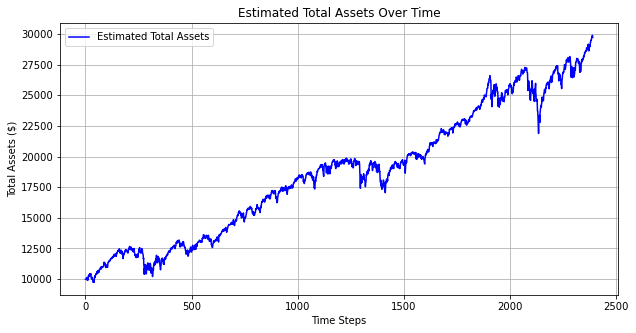

Final profits: 29723.60846306262


In [15]:
import matplotlib.pyplot as plt

def test_ddqn(test_env, Q, Q_ast, buy_threshold=0.1, sell_threshold=0.8):
    # 重置环境并获取初始状态
    pobs = test_env.reset()
    test_env.profits = 10000  # 如果需要的话，重置初始资金
    test_acts = []
    test_rewards = []
    test_profits = [test_env.profits]  # 记录每一步后的利润
    estimated_total_assets = [test_env.profits]  # 包括估算的持股价值的总资产列表

    while not test_env.done:
        # 使用训练好的DDQN模型选择行动
        q_values = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
        softmax_q_values = F.softmax(q_values).data.ravel()
        action = np.random.choice(3, p=softmax_q_values)
        action_prob = softmax_q_values[action]
        amount = action_prob

        # 根据阈值判断是否执行买入或卖出
        if action == 1 and action_prob < buy_threshold:
            action = 0
            amount = 0
        elif action == 2 and action_prob < sell_threshold:
            action = 0
            amount = 0

        obs, reward, done = test_env.step(action, amount)
        if done:
            break
        test_acts.append(action)
        test_rewards.append(reward)
        pobs = obs
        test_profits.append(test_env.profits)

        # 估算总资产（不实际卖出股票）
        stock_value = sum(c * test_env.data.iloc[test_env.t]['Close'] for c in test_env.count)
        total_assets = test_env.profits + stock_value
        estimated_total_assets.append(total_assets)
    # 测试最后一天，将所有持股转换为现金
    final_stock_value = sum(c * test_env.data.iloc[-1]['Close'] for c in test_env.count)
    final_profits = test_env.profits + final_stock_value
    estimated_total_assets[-1] = final_profits  # 更新最后的总资产估计值
    #print("Test actions:", test_acts)
    #print("Test rewards:", test_rewards)
    

    # 绘制总资产变化的折线图
    plt.figure(figsize=(10, 5))
    plt.plot(estimated_total_assets, label='Estimated Total Assets', color='blue')
    plt.title('Estimated Total Assets Over Time')
    plt.xlabel('Time Steps')
    plt.ylabel('Total Assets ($)')
    plt.legend()
    plt.grid(True)
    plt.show()
    print("Final profits:", final_profits)
    return test_acts, test_rewards, final_profits

class Q_Network(chainer.Chain):

    def __init__(self, input_size, hidden_size, output_size):
        super(Q_Network, self).__init__(
            fc1 = L.Linear(input_size, hidden_size),
            fc2 = L.Linear(hidden_size, hidden_size),
            fc3 = L.Linear(hidden_size, output_size)
        )

    def __call__(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        y = self.fc3(h)
        return y

    def reset(self):
        self.zerograds() 
# 确保以下是您实际调用测试函数的部分
test_data = test  # 确保已正确设置测试数据
test_env = Environment1(data=test_data, history_t=90)

Q_loaded = Q_Network(input_size=test_env.history_t+1, hidden_size=100, output_size=3)
chainer.serializers.load_npz('2001_Gold_ddqn_behavior_model.npz', Q_loaded)

Q_ast_loaded = Q_Network(input_size=test_env.history_t+1, hidden_size=100, output_size=3)
chainer.serializers.load_npz('2001_Gold_ddqn_target_model.npz', Q_ast_loaded)

# 运行测试
test_acts, test_rewards, test_profits = test_ddqn(test_env, Q_loaded, Q_ast_loaded)

In [16]:
# Dueling Double DQN

def train_dddqn(env):

    """ <<< Double DQN -> Dueling Double DQN
    class Q_Network(chainer.Chain):

        def __init__(self, input_size, hidden_size, output_size):
            super(Q_Network, self).__init__(
                fc1 = L.Linear(input_size, hidden_size),
                fc2 = L.Linear(hidden_size, hidden_size),
                fc3 = L.Linear(hidden_size, output_size)
            )

        def __call__(self, x):
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            y = self.fc3(h)
            return y

        def reset(self):
            self.zerograds()
    === """
    class Q_Network(chainer.Chain):

        def __init__(self, input_size, hidden_size, output_size):
            super(Q_Network, self).__init__(
                fc1 = L.Linear(input_size, hidden_size),
                fc2 = L.Linear(hidden_size, hidden_size),
                fc3 = L.Linear(hidden_size, hidden_size//2),
                fc4 = L.Linear(hidden_size, hidden_size//2),
                state_value = L.Linear(hidden_size//2, 1),
                advantage_value = L.Linear(hidden_size//2, output_size)
            )
            self.input_size = input_size
            self.hidden_size = hidden_size
            self.output_size = output_size

        def __call__(self, x):
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            hs = F.relu(self.fc3(h))
            ha = F.relu(self.fc4(h))
            state_value = self.state_value(hs)
            advantage_value = self.advantage_value(ha)
            advantage_mean = (F.sum(advantage_value, axis=1)/float(self.output_size)).reshape(-1, 1)
            q_value = F.concat([state_value for _ in range(self.output_size)], axis=1) + (advantage_value - F.concat([advantage_mean for _ in range(self.output_size)], axis=1))
            return q_value

        def reset(self):
            self.zerograds()
    """ >>> """

    Q = Q_Network(input_size=env.history_t+1, hidden_size=100, output_size=3)
    Q_ast = copy.deepcopy(Q)
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(Q)

    epoch_num = 200
    step_max = len(env.data)-1
    memory_size = 200
    batch_size = 50
    epsilon = 1.0
    epsilon_decrease = 1e-3
    epsilon_min = 0.1
    start_reduce_epsilon = 200
    train_freq = 10
    update_q_freq = 20
    gamma = 0.97
    confidence_threshold_buy = 0.1
    confidence_threshold_sell = 0.8
    show_log_freq = 1

    memory = []
    total_step = 0
    total_rewards = []
    total_losses = []

    start = time.time()
    print('\t'.join(map(str, ['epoch','profit','          ','buy','sell','hold'])))
    for epoch in range(epoch_num):

        pobs = env.reset()
        step = 0
        done = False
        total_reward = 0
        total_loss = 0
        RandAct = 0
        NRandAct = 0
        while not done and step < step_max:
            #if step==2264 :
            #    env.profits=10000
            #    env.count=0
            # select act
            pact = np.random.randint(3)
            amount = 0.25
            if np.random.rand() > epsilon:
                q_values = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
                softmax_q_values = F.softmax(q_values).data
                #if step==0:print('\t'.join(map(str, [pact])))
                #max_confidence = softmax_q_values
                amount = softmax_q_values.ravel()[pact]
                pact = np.random.choice(3, p=softmax_q_values.ravel())
                # act = 0: stay, 1: buy, 2: sell
                if pact == 2:
                    if amount < confidence_threshold_sell:  # confidence_threshold 阈值 
                        pact = 0
                if pact == 1:
                    if amount < confidence_threshold_buy:  # confidence_threshold 阈值
                        pact = 0
                #if epoch > 100 : print('\t'.join(map(str, [pact,amount])))
                NRandAct+=1
            else:
                RandAct+=1
                if pact==0: amount = 0.5
            # act
            obs, reward, done = env.step(pact,amount)

            # add memory
            memory.append((pobs, pact, reward, obs, done))
            if len(memory) > memory_size:
                memory.pop(0)

            # train or update q
            if len(memory) == memory_size:
                if total_step % train_freq == 0:
                    shuffled_memory = np.random.permutation(memory)
                    memory_idx = range(len(shuffled_memory))
                    for i in memory_idx[::batch_size]:
                        batch = np.array(shuffled_memory[i:i+batch_size])
                        b_pobs = np.array(batch[:, 0].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_pact = np.array(batch[:, 1].tolist(), dtype=np.int32)
                        b_reward = np.array(batch[:, 2].tolist(), dtype=np.int32)
                        b_obs = np.array(batch[:, 3].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_done = np.array(batch[:, 4].tolist(), dtype=np.bool)

                        q = Q(b_pobs)
                        """ <<< DQN -> Double DQN
                        maxq = np.max(Q_ast(b_obs).data, axis=1)
                        === """
                        indices = np.argmax(q.data, axis=1)
                        maxqs = Q_ast(b_obs).data
                        """ >>> """
                        target = copy.deepcopy(q.data)
                        for j in range(batch_size):
                            """ <<< DQN -> Double DQN
                            target[j, b_pact[j]] = b_reward[j]+gamma*maxq[j]*(not b_done[j])
                            === """
                            target[j, b_pact[j]] = b_reward[j]+gamma*maxqs[j, indices[j]]*(not b_done[j])
                            """ >>> """
                        Q.reset()
                        loss = F.mean_squared_error(q, target)
                        total_loss += loss.data
                        loss.backward()
                        optimizer.update()

                if total_step % update_q_freq == 0:
                    Q_ast = copy.deepcopy(Q)

            # epsilon
            if epsilon > epsilon_min and total_step > start_reduce_epsilon:
                epsilon -= epsilon_decrease

            # next step
            total_reward += reward
            pobs = obs
            step += 1
            total_step += 1

        total_rewards.append(total_reward)
        total_losses.append(total_loss)

        if (epoch+1) % show_log_freq == 0:
            log_reward = sum(total_rewards[((epoch+1)-show_log_freq):])/show_log_freq
            log_loss = sum(total_losses[((epoch+1)-show_log_freq):])/show_log_freq
            log_profits = env.profits
            if len(env.count) != 0:
                for i in range(0,len(env.positions)):
                    log_profits += env.count[i]*env.data.iloc[env.t, :]['Close']
            else :
                log_profits = env.profits
            elapsed_time = time.time()-start
            print('\t'.join(map(str, [epoch+1,log_profits,env.Act1,env.Act2,env.Act0])))
            print('\t'.join(map(str, [epoch+1,env.RW_p,env.RW_n,env.RW_p_v,env.RW_n_v])))
            start = time.time()
    chainer.serializers.save_npz('2001_Gold_dueling_ddqn_model.npz', Q)
    chainer.serializers.save_npz('2001_Gold_dueling_ddqn_target_model.npz', Q_ast)        
    return Q, total_losses, total_rewards

In [17]:
Q, total_losses, total_rewards = train_dddqn(Environment1(train))

epoch	profit	          	buy	sell	hold
1	7556.8691371729765	687	302	1399
1	360	321	14138.127505168051	15911.545655651293
2	6448.699851764583	687	109	1592
2	366	313	10805.630689872003	13677.28294933984
3	6837.144925654602	632	87	1668
3	285	304	8803.114571067688	11400.189483801383
4	8423.990276909213	753	86	1549
4	432	305	11401.827509902367	12377.061082466023
5	9792.406083140037	721	94	1573
5	366	350	12341.538735388742	12482.347142155795
6	6916.173201520504	754	80	1554
6	465	269	10753.233137395411	12717.91180344315
7	8011.022932446348	760	76	1552
7	394	356	10383.677534151666	11840.044851139524
8	8309.908272846624	719	91	1578
8	385	322	10107.838385729257	11766.680711212748
9	6421.499893841613	784	73	1531
9	435	325	8222.042057697914	11040.60897110953
10	12781.899225291982	739	91	1558
10	457	266	14858.97307261563	11529.243923811931
11	7509.802180089423	836	81	1471
11	466	326	9207.442360065405	11190.555482485921
12	7939.314278934026	744	91	1553
12	373	352	10995.508551607529	11800.296624299403

102	7146.033778687741	576	78	1733
102	281	277	10309.15451559603	12759.87253227294
103	8021.120718619978	635	83	1670
103	327	298	10369.71420499275	12037.07774332882
104	6608.120384176246	577	73	1738
104	324	248	6718.424256847398	10106.631586399884
105	7738.1999088726825	581	99	1706
105	310	264	12473.91085634175	14114.584836205371
106	8168.667687188022	636	78	1674
106	347	286	8492.883132784513	10313.206092358896
107	8919.268296137468	657	79	1652
107	345	292	11007.297177760032	12087.580425546548
108	8672.069105800185	639	82	1667
108	341	251	10108.427162438113	11072.822300650152
109	7725.347903721222	610	73	1705
109	296	297	9884.295208569321	10824.982934537278
110	6162.412002801532	596	82	1709
110	319	269	7368.7339809552195	10793.081956453156
111	7913.780786568529	608	66	1714
111	321	273	8886.713786647928	10384.556731195053
112	6754.925939753023	639	90	1659
112	327	294	9714.164877219775	11802.122533918628
113	7511.65772301041	596	87	1704
113	325	262	9917.898093390186	11933.67116538987
114	

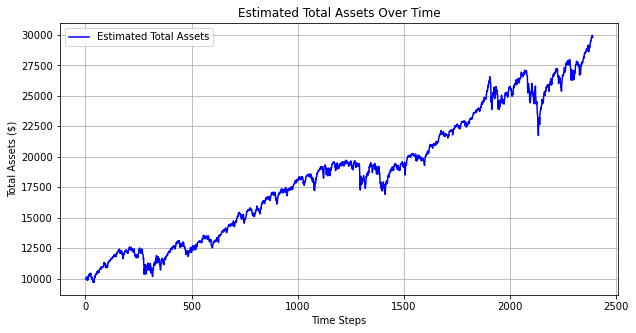

Final profits: 29789.17187664554


In [18]:
import plotly.graph_objects as go
import numpy as np

def test_dueling_ddqn(test_env, Q, buy_threshold=0.1, sell_threshold=0.8):
    pobs = test_env.reset()
    test_env.profits = 10000  # 重置初始资金
    test_acts = []
    test_rewards = []
    test_profits = []
    estimated_total_assets = [test_env.profits]  # 包括估算的持股价值的总资产列表
    while not test_env.done:
        q_values = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
        softmax_q_values = F.softmax(q_values).data.ravel()
        action = np.random.choice(3, p=softmax_q_values)  # 随机选择行动，基于概率分布
        action_prob = softmax_q_values[action]

        # 设置交易的金额或数量，这里假设简单地将概率值转换为金额或比例
        amount = action_prob

        # 考虑不同行动的阈值
        if action == 1 and action_prob < buy_threshold:  # 买入行动的阈值判断
            action = 0  # 如果买入概率低于买入阈值，则不买入
            amount = 0
        elif action == 2 and action_prob < sell_threshold:  # 卖出行动的阈值判断
            action = 0  # 如果卖出概率低于卖出阈值，则不卖出
            amount = 0

        obs, reward, done = test_env.step(action, amount)
        test_acts.append(action)
        test_rewards.append(reward)
        pobs = obs

        # 估计每日的现有资金（假设所有持仓都卖出但不真正执行）
        simulated_profits = test_env.profits + sum(pos * test_env.data.iloc[test_env.t, :]['Close'] for pos in test_env.count)
        test_profits.append(simulated_profits)
        estimated_total_assets.append(simulated_profits)
    # 绘制折线图显示每日利润变化
    plt.figure(figsize=(10, 5))
    plt.plot(estimated_total_assets, label='Estimated Total Assets', color='blue')
    plt.title('Estimated Total Assets Over Time')
    plt.xlabel('Time Steps')
    plt.ylabel('Total Assets ($)')
    plt.legend()
    plt.grid(True)
    plt.show()
    test_env.profits = simulated_profits
    return test_acts, test_rewards, test_env.profits

def load_and_test_dueling_ddqn(test_env):
    class Q_Network(chainer.Chain):

        def __init__(self, input_size, hidden_size, output_size):
            super(Q_Network, self).__init__(
                fc1 = L.Linear(input_size, hidden_size),
                fc2 = L.Linear(hidden_size, hidden_size),
                fc3 = L.Linear(hidden_size, hidden_size//2),
                fc4 = L.Linear(hidden_size, hidden_size//2),
                state_value = L.Linear(hidden_size//2, 1),
                advantage_value = L.Linear(hidden_size//2, output_size)
            )
            self.input_size = input_size
            self.hidden_size = hidden_size
            self.output_size = output_size

        def __call__(self, x):
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            hs = F.relu(self.fc3(h))
            ha = F.relu(self.fc4(h))
            state_value = self.state_value(hs)
            advantage_value = self.advantage_value(ha)
            advantage_mean = (F.sum(advantage_value, axis=1)/float(self.output_size)).reshape(-1, 1)
            q_value = F.concat([state_value for _ in range(self.output_size)], axis=1) + (advantage_value - F.concat([advantage_mean for _ in range(self.output_size)], axis=1))
            return q_value

        def reset(self):
            self.zerograds()
    Q_loaded = Q_Network(input_size=test_env.history_t+1, hidden_size=100, output_size=3)
    chainer.serializers.load_npz('2001_Gold_dueling_ddqn_model.npz', Q_loaded)
    test_acts, test_rewards, test_profits = test_dueling_ddqn(test_env, Q_loaded, buy_threshold=0.1, sell_threshold=0.6)
    #print("Test actions:", test_acts)
    #print("Test rewards:", test_rewards)
    print("Final profits:", test_profits)

test_data = test  
test_env = Environment1(data=test_data, history_t=90)
load_and_test_dueling_ddqn(test_env)